**qAIntum.ai**

# **Quantum Neural Network (QNN) 4-qumode MNIST Classifier Tutorial**

This note is an example of using Photonic Analog (PA) QNN for multi output classification. This is an application of the original work ["Continuous Variable Quantum MNIST Classifiers"](https://arxiv.org/abs/2204.01194). Classical and Continuous Variable Quantum hybrid network: Classical layers using keras dense and quantum layers using Pennylane

Compared to Classical Neural Networks, PA QNNs have a reduced number of parameters to train and converge faster with fewer epochs. However, this is a quantum algorithm simulated on classical computers hence the training time for quantum circuits tend to be longer than classical models.

The dataset used in this example can be found https://yann.lecun.com/exdb/mnist/.

This file is organized in the following order:
0. Install and import necessary packages
1. Load and preprocess data 
2. Data encoding
3. QNN model
   * QNN layer
   * QNN circuit
   * Model building
4. Model training
5. Evaluation

For the open source repository, refer to https://github.com/qaintumai/quantum.

Dependencies: keras-nightly==2.5.0.dev2021032900 PennyLane==0.17.0 StrawberryFields==0.18.0 tensorflow-2.4.0-cp38-cp38-macosx_10_9_x86_64.whl

## 0. Importing necessary packages


In [10]:
!pip install keras-nightly==2.5.0.dev2021032900
!pip install PennyLane==0.17.0
!pip install StrawberryFields==0.19.0
!pip install tensorflow==2.4.0
!pip install torchsummary
!pip show pennylane


DEPRECATION: Loading egg at /Users/maxsivry/anaconda3/lib/python3.11/site-packages/fonttools-4.45.1-py3.11-macosx-10.9-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
DEPRECATION: Loading egg at /Users/maxsivry/anaconda3/lib/python3.11/site-packages/fonttools-4.45.1-py3.11-macosx-10.9-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
DEPRECATION: Loading egg at /Users/maxsivry/anaconda3/lib/python3.11/site-packages/fonttools-4.45.1-py3.11-macosx-10.9-x86_64.egg is dep

DEPRECATION: Loading egg at /Users/maxsivry/anaconda3/lib/python3.11/site-packages/fonttools-4.45.1-py3.11-macosx-10.9-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
ERROR: Could not find a version that satisfies the requirement tensorflow==2.4.0 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2)
ERROR: No matching distribution found for tensorflow==2.4.0

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
DEPRECATION: Loading egg at /Users/maxsivry/anaconda3/lib/python3.11/site-packages/fonttools-4.45.1-py3.11-macosx-10.9-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to us

In [18]:
!pip install strawberryfields
!pip install pennylane-sf

DEPRECATION: Loading egg at /Users/maxsivry/anaconda3/lib/python3.11/site-packages/fonttools-4.45.1-py3.11-macosx-10.9-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
DEPRECATION: Loading egg at /Users/maxsivry/anaconda3/lib/python3.11/site-packages/fonttools-4.45.1-py3.11-macosx-10.9-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Using cached PennyLane_SF-0.29.1-py3-none-any.whl.metadata (7.0 kB)
  Using cached StrawberryFields-0.23.0-py3-none-any.whl.metadata (7.6 kB)
  Using cached PennyLane-0.29.1-py3-none-any.whl.metadata (8.7 kB)
  Using cached semantic_version-2.10

Using cached PennyLane_SF-0.29.1-py3-none-any.whl (29 kB)
Using cached PennyLane-0.29.1-py3-none-any.whl (1.3 MB)
Using cached StrawberryFields-0.23.0-py3-none-any.whl (4.9 MB)
Using cached semantic_version-2.10.0-py2.py3-none-any.whl (15 kB)
  Attempting uninstall: semantic-version
    Found existing installation: semantic-version 2.6.0
    Uninstalling semantic-version-2.6.0:
      Successfully uninstalled semantic-version-2.6.0
  Attempting uninstall: strawberryfields
    Found existing installation: StrawberryFields 0.19.0
    Uninstalling StrawberryFields-0.19.0:
      Successfully uninstalled StrawberryFields-0.19.0
  Attempting uninstall: pennylane
    Found existing installation: PennyLane 0.17.0
    Uninstalling PennyLane-0.17.0:
      Successfully uninstalled PennyLane-0.17.0

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [32]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torchsummary import summary
import pennylane as qml
import numpy as np

import matplotlib.pyplot as plt

## 0. Loading data and preprocessing

In [12]:
# Define a transform to convert PIL images to tensors and normalize the pixel values
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),  # Convert images to tensors with pixel values in range [0, 1]
])

# Download and load the training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=False)

# Download and load the test dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False)

# Extract the full dataset from the DataLoader (this loads the entire dataset into memory)
X_train, Y_train = next(iter(trainloader))
X_test, Y_test = next(iter(testloader))

# Convert images to numpy arrays
X_train = X_train.numpy()
X_test = X_test.numpy()

# Convert labels to numpy arrays
Y_train = Y_train.numpy()
Y_test = Y_test.numpy()

# Print shapes to verify
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

# Verify that pixel values are in the range [0, 1]
print("X_train min and max values:", X_train.min(), X_train.max())
print("X_test min and max values:", X_test.min(), X_test.max())

X_train shape: (60000, 1, 28, 28)
Y_train shape: (60000,)
X_test shape: (10000, 1, 28, 28)
Y_test shape: (10000,)
X_train min and max values: 0.0 1.0
X_test min and max values: 0.0 1.0


In [13]:
def one_hot(labels):  
       
    depth =  2**4                       # 10 classes + 6 zeros for padding
    indices = labels.astype(np.int32)    
    one_hot_labels = np.eye(depth)[indices].astype(np.float32) 
    
    return one_hot_labels

# one-hot encoded labels, each label of length cutoff dimension**2
y_train, y_test = one_hot(Y_train), one_hot(Y_test)

# using only 600 samples for training in this experiment
n_samples = 600
test_samples = 100
X_train, X_test, y_train, y_test = X_train[:n_samples], X_test[:test_samples], y_train[:n_samples], y_test[:test_samples]

## 1. Classical circuit

Define classical layers using Keras Sequential. Take in 28x28 image matrices, flatten, and output vectors of length 30. 2 hidden layers with ELU activation.

In [14]:
model = nn.Sequential(
    nn.Flatten(),  # Flatten the input
    nn.Linear(28 * 28, 392),  # Dense layer with 392 units
    nn.ELU(),  # ELU activation function
    nn.Linear(392, 196),  # Dense layer with 196 units
    nn.ELU(),  # ELU activation function
    nn.Linear(196, 98),  # Dense layer with 98 units
    nn.Linear(98, 49),  # Dense layer with 49 units
    nn.ELU(),  # ELU activation function
    nn.Linear(49, 30)  # Dense layer with 30 units
)

summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 392]         307,720
               ELU-3                  [-1, 392]               0
            Linear-4                  [-1, 196]          77,028
               ELU-5                  [-1, 196]               0
            Linear-6                   [-1, 98]          19,306
            Linear-7                   [-1, 49]           4,851
               ELU-8                   [-1, 49]               0
            Linear-9                   [-1, 30]           1,500
Total params: 410,405
Trainable params: 410,405
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.57
Estimated Total Size (MB): 1.59
-------------------------------------------

## 2. Data encoding circuit

Encode the output vectors from the classical network into quantum states using the vector entries as parameters of continuous variable gates. 

In [15]:
def encode_data(x):
    qml.Squeezing(x[0], x[1], wires=0)
    qml.Squeezing(x[2], x[3], wires=1)
    qml.Squeezing(x[4], x[5], wires=2)
    qml.Squeezing(x[6], x[7], wires=3)
    
    qml.Beamsplitter(x[8], x[9], wires=[0,1])
    qml.Beamsplitter(x[10], x[11], wires=[1,2])
    qml.Beamsplitter(x[12], x[13], wires=[2,3])
    
    qml.Rotation(x[14], wires=0)
    qml.Rotation(x[15], wires=1)
    qml.Rotation(x[16], wires=2)
    qml.Rotation(x[17], wires=3)    
    
    qml.Displacement(x[18], x[19], wires=0)
    qml.Displacement(x[20], x[21], wires=1)
    qml.Displacement(x[22], x[23], wires=2)
    qml.Displacement(x[24], x[25], wires=3) 
    
    qml.Kerr(x[26], wires=0)
    qml.Kerr(x[27], wires=1)
    qml.Kerr(x[28], wires=2)
    qml.Kerr(x[29], wires=3)

## 3. Qauntum neural network circuit

In [16]:
def layer(v):
    
    # Linear transformation W = Interferemeter, squeezers, interferometer
    # Interferometer 1
    qml.Beamsplitter(v[0], v[1], wires=[0,1])
    qml.Beamsplitter(v[2], v[3], wires=[1,2])
    qml.Beamsplitter(v[4], v[5], wires=[2,3])
    
    qml.Rotation(v[6], wires=0)
    qml.Rotation(v[7], wires=1)
    qml.Rotation(v[8], wires=2)
    qml.Rotation(v[9], wires=3)
    
    # Squeezers
    qml.Squeezing(v[10], 0.0, wires=0)
    qml.Squeezing(v[11], 0.0, wires=1)
    qml.Squeezing(v[12], 0.0, wires=2)
    qml.Squeezing(v[13], 0.0, wires=3) 
    
    # Interferometer 2
    qml.Beamsplitter(v[14], v[15], wires=[0,1])
    qml.Beamsplitter(v[16], v[17], wires=[1,2])
    qml.Beamsplitter(v[18], v[19], wires=[2,3])
    
    qml.Rotation(v[20], wires=0)
    qml.Rotation(v[21], wires=1)
    qml.Rotation(v[22], wires=2)
    qml.Rotation(v[23], wires=3)
    
    # Bias addition
    qml.Displacement(v[24], 0.0, wires=0)
    qml.Displacement(v[25], 0.0, wires=1)
    qml.Displacement(v[26], 0.0, wires=2)
    qml.Displacement(v[27], 0.0, wires=3)
    
    # Non-linear activation
    qml.Kerr(v[28], wires=0)
    qml.Kerr(v[29], wires=1)
    qml.Kerr(v[30], wires=2)
    qml.Kerr(v[31], wires=3)

## 4. Quantum device

For the expression of qumodes in Fock basis, choose a "strawberryfields.fock" device. Define the number of qumodes and cutoff dimension. Run the data encoding circuit and quantum neural network circuit. The probability measurement method (qml.probs(wires)) returns vectors of size 2^4 = 16 (cutoff_dim^num_modes).

In [22]:
num_modes = 4
cutoff_dim = 2

# select a devide 
dev = qml.device("strawberryfields.fock", wires=num_modes, cutoff_dim=cutoff_dim) 

@qml.qnode(dev, interface="torch")
def quantum_nn(inputs, var):
    # Encode input x into quantum state
    encode_data(inputs)

    # iterative quantum layers
    for v in var:
        layer(v)

    return qml.probs(wires=[0, 1, 2, 3])  # Measurement

## 5. Hybrid circuit

In [29]:
weight_shape = {'var': (4,32)}          # 4 layers and 32 parameters per layer, Keras layer will initialize.

# Define the quantum layer using TorchLayer
quantum_layer = qml.qnn.TorchLayer(quantum_nn, weight_shape)
# add to the classical sequential model
model.add_module('quantum_layer', quantum_layer)

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=392, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=392, out_features=196, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=196, out_features=98, bias=True)
  (6): Linear(in_features=98, out_features=49, bias=True)
  (7): ELU(alpha=1.0)
  (8): Linear(in_features=49, out_features=30, bias=True)
  (quantum_layer): <Quantum Torch Layer: func=quantum_nn>
)


## 6. Loss function and optimizer

In [43]:
# Define the learning rate
lr = 0.02

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=lr)

# Define the loss function
criterion = nn.CrossEntropyLoss()

print(inputs.view(inputs.size(0), -1))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


## 7. Training

In [42]:
epochs = 70
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in trainloader:
        inputs = inputs.view(inputs.size(0), -1) 
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_inputs, val_labels in testloader:
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_loss /= len(testloader)
    val_acc = 100 * val_correct / val_total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/maxsivry/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/16/pyq7sqpn54lf7hj_4295jgnm0000gn/T/ipykernel_45296/729612413.py", line 11, in <module>
    outputs = model(inputs)
              ^^^^^^^^^^^^^
  File "/Users/maxsivry/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/maxsivry/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1520, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/maxsivry/anaconda3/lib/python3.11/site-packages/torch/nn/modules/container.py", line 217, in forward
    input = module(input)
            ^^^^^^^^^^^^^
  File "/Users/maxsivry/anaconda3/lib/python3

In [34]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 392)            │       307,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 196)            │        77,028 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 98)             │        19,306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 49)             │         4,851 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 30)             │         1,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 410,405 (1.57 MB)

 Trainable params: 410,405 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

## 8. Loss and accuracy graphs

NameError: name 'hybrid' is not defined

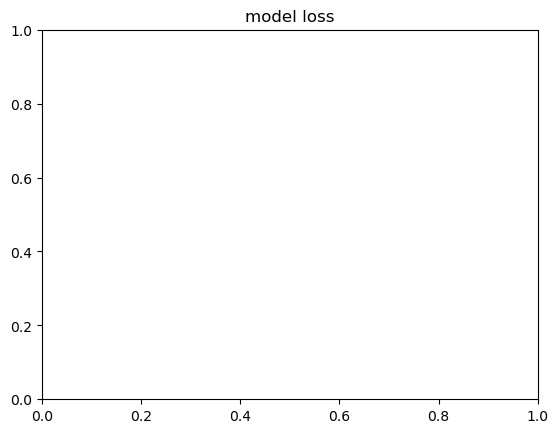

In [44]:
# ===================================================================================
#                                  Loss History Plot
# ===================================================================================

plt.title('model loss')
plt.plot(hybrid.history['loss'], '-g')
plt.ylabel('loss')
plt.show()

NameError: name 'hybrid' is not defined

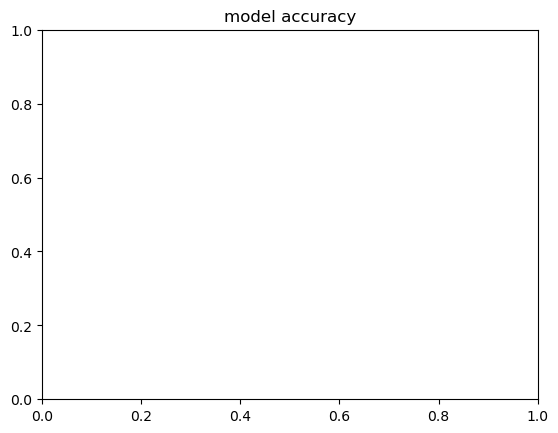

In [45]:
# ===================================================================================
#                                Accuracy History Plot
# ===================================================================================

plt.title('model accuracy')
plt.plot(hybrid.history['accuracy'], '-g')
plt.ylabel('accuracy')
plt.show()